In [83]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import astropy.io.ascii as at
import astropy.io.fits as fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
import astropy.units as u
import matplotlib.ticker
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.font_manager import FontProperties
import palettable

from hypra.utils import cat_match, cat_io

# Just crossmatching against Gaia

In [84]:
gaia = at.read("gaia_vizier_allhyads_full.csv",delimiter="|",
              data_start=3)
print(gaia.dtype)
gpos = SkyCoord(gaia["RAJ2000"],gaia["DEJ2000"],unit=u.degree)

[('_r', '<f8'), ('DR2Name', '<U28'), ('RA_ICRS', '<f8'), ('e_RA_ICRS', '<f8'), ('DE_ICRS', '<f8'), ('e_DE_ICRS', '<f8'), ('SolID', '<i8'), ('Source', '<i8'), ('RandomI', '<i8'), ('Epoch', '<f8'), ('Plx', '<f8'), ('e_Plx', '<f8'), ('RPlx', '<f8'), ('pmRA', '<f8'), ('e_pmRA', '<f8'), ('pmDE', '<f8'), ('e_pmDE', '<f8'), ('RADEcor', '<f8'), ('RAPlxcor', '<f8'), ('RApmRAcor', '<f8'), ('RApmDEcor', '<f8'), ('DEPlxcor', '<f8'), ('DEpmRAcor', '<f8'), ('DEpmDEcor', '<f8'), ('PlxpmRAcor', '<f8'), ('PlxpmDEcor', '<f8'), ('pmRApmDEcor', '<f8'), ('NAL', '<i8'), ('NAC', '<i8'), ('NgAL', '<i8'), ('NbAL', '<i8'), ('gofAL', '<f8'), ('chi2AL', '<f8'), ('epsi', '<f8'), ('sepsi', '<f8'), ('Solved', '<i8'), ('APF', '<i8'), ('WAL', '<f8'), ('pscol', '<f8'), ('e_pscol', '<f8'), ('fvarpi', '<f8'), ('MatchObsA', '<i8'), ('Nper', '<i8'), ('amax', '<f8'), ('type', '<i8'), ('MatchObs', '<i8'), ('Dup', '<i8'), ('o_Gmag', '<i8'), ('FG', '<f8'), ('e_FG', '<f8'), ('RFG', '<f8'), ('Gmag', '<f8'), ('e_Gmag', '<f8'), ('

In [85]:
# Gaia filtering (from the DR2 HRD paper):
#    RPlx > 10
#    RFG>50
#    RFBP>20
#    RFRP>20
#    E(BR/RP) < 1.3+0.06*(BP-RP)**2
#    E(BR/RP) > 1.0+0.015*(BP-RP)**2 # phot_bp_rp_excess_factor
#    Nper>8 # (visibility periods)
#    chi2AL/(NgAL-5)<1.44*greatest(1,exp(-0.4*(Gmag-19.5)))

#    astrometric_chi2_al/(astrometric_n_good_obs_al-5)<1.44*greatest(1,exp(-0.4*(phot_g_mean_mag-19.5)))

# - astrometric_excess_noise<1 criterion, 
#   but this is less optimised for the bright stars 
#   because of the degrees of freedom (DOF) issue (Lindegren et al. 2018, Appendix A).
# photometric cuts may remove variable stars!

In [86]:
phot_excess = ((gaia["E(BR/RP)"] < (1.3+0.06*gaia["BP-RP"]**2)) &
               (gaia["E(BR/RP)"] > (1.0+0.015*gaia["BP-RP"]**2)))

gexp = np.exp(-0.4*(gaia["Gmag"]-19.5))
gexp[gexp<1] = 1
astrom = (gaia["chi2AL"]/(gaia["NgAL"]-5)) < (1.44*gexp)

hrd_filter = ((gaia["RPlx"]>10) & (gaia["RFG"]>50) & (gaia["RFBP"]>20)
             & (gaia["RFRP"]>20) & phot_excess & (gaia["Nper"]>8)
             & astrom)

In [87]:
hdat,_,_,_ = cat_io.get_data("H")
hpos = SkyCoord(hdat["RA"],hdat["DEC"],unit=u.degree)

In [88]:
# Match EPIC IDs
epic_list = at.read("mast_search_13064.csv",data_start=2)
print(epic_list.dtype)
mpos = SkyCoord(epic_list["RA (J2000)"], epic_list["Dec (J2000)"],
               unit=(u.hourangle,u.degree))
idx, sep, _ = hpos.match_to_catalog_sky(mpos)
print(len(idx),len(hpos),len(mpos))

good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]
print(len(good_match),len(good_idx),len(np.unique(good_idx)))

hdat["EPIC_ID"][good_match] = epic_list["K2 ID"][good_idx]

[('K2 ID', '<i8'), ('Dataset Name', '<U17'), ('Campaign', '<i8'), ('Object type', '<U14'), ('RA (J2000)', '<U12'), ('Dec (J2000)', '<U12'), ('Target Type', '<U2'), ('Ref', '<i8'), ('Actual Start Time', '<U19'), ('Actual End Time', '<U19'), ('Investigation ID', '<U103'), ('R Mag', '<f8'), ('R Mag Err', '<f8'), ('J Mag', '<f8'), ('J Mag Err', '<f8'), ('KEP Mag', '<f8'), ('Kep Flag', '<U3'), ('Hip ID', '<i8'), ('Tyc ID', '<U11'), ('SDSS ID', '<U20'), ('UCAC ID', '<U10'), ('2MASS ID', '<U16'), ('2MASS Flag', '<U19'), ('Module', '<i8'), ('Output', '<i8'), ('Channel', '<i8'), ('High-Level Science Products', '<i8')]
786 786 132
132 132 132


In [89]:
hdat = Table(hdat)

In [90]:
idx, sep, _ = hpos.match_to_catalog_sky(gpos)
print(len(idx),len(sep),len(hpos),len(gpos))

786 786 786 999


In [91]:
good_match = np.where(sep<(5*u.arcsec))[0]
good_idx = idx[good_match]

print(len(good_idx),len(np.unique(good_idx)))
print(max(good_idx))

784 784
996


In [92]:
hdat["GAIA_ID"] = np.zeros(len(hdat),"int64")
hdat["GAIA_ID"][good_match] = gaia["Source"][good_idx]
hdat["GAIA_SEP"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_SEP"][good_match] = sep[good_match].to(u.arcsec).value

In [93]:
hdat["GAIA_QUAL"] = np.zeros(len(hdat),bool)
hdat["GAIA_PARALLAX"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_PARALLAX_ERR"] = np.zeros(len(hdat))*np.nan

hdat["GAIA_QUAL"][good_match] = hrd_filter[good_idx]
hdat["GAIA_PARALLAX"][good_match] = gaia["Plx"][good_idx]
hdat["GAIA_PARALLAX_ERR"][good_match] = gaia["e_Plx"][good_idx]

In [94]:
print(len(np.where(hdat["GAIA_QUAL"])[0]),"Good Gaia Stars")
print(len(np.where(hdat["GAIA_QUAL"]==False)[0]),"Low Quality Gaia Stars")
print(len(np.where((hdat["GAIA_QUAL"]==False) & (hdat["BINARY"]>0))[0]),"Low Q, binary")

598 Good Gaia Stars
188 Low Quality Gaia Stars
81 Low Q, binary


In [95]:
hdat["GAIA_PMRA"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_PMDEC"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_PMRA_ERR"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_PMDEC_ERR"] = np.zeros(len(hdat))*np.nan

hdat["GAIA_PMRA"][good_match] = gaia["pmRA"][good_idx]
hdat["GAIA_PMRA_ERR"][good_match] = gaia["e_pmRA"][good_idx]
hdat["GAIA_PMDEC"][good_match] = gaia["pmDE"][good_idx]
hdat["GAIA_PMDEC_ERR"][good_match] = gaia["e_pmDE"][good_idx]

In [96]:
hdat["GAIA_RV"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_RV_ERR"] = np.zeros(len(hdat))*np.nan

hdat["GAIA_RV"][good_match] = gaia["RV"][good_idx]
hdat["GAIA_RV_ERR"][good_match] = gaia["e_RV"][good_idx]

In [97]:
hdat["GAIA_G"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_BP"] = np.zeros(len(hdat))*np.nan
hdat["GAIA_RP"] = np.zeros(len(hdat))*np.nan

hdat["GAIA_G"][good_match] = gaia["Gmag"][good_idx]
hdat["GAIA_BP"][good_match] = gaia["BPmag"][good_idx]
hdat["GAIA_RP"][good_match] = gaia["RPmag"][good_idx]

## Also compare to the Gaia HRD cluster list

In [98]:
gaia_hrd = at.read("gaia_HRD_Hyades.tsv",delimiter="|",data_start=3)
gaia_hrd.dtype

print(len(gaia_hrd),len(np.intersect1d(hdat["GAIA_ID"],gaia_hrd["Source"])))

hdat["HRD"] = np.zeros(len(hdat),bool)

for sid in gaia_hrd["Source"]:
    loc = np.where(hdat["GAIA_ID"]==sid)[0]
    if len(loc)==1:
        hdat["HRD"][loc] = True
    else:
        continue

515 409


# Comparing earlier values with Gaia

Text(0,0.5,'HIP Parallax')

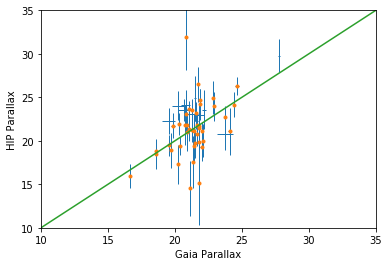

In [99]:
good_hip = hdat["HIP_PARALLAX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_hip],hdat["HIP_PARALLAX"][good_hip],
            yerr=hdat["HIP_PAR_ERR"][good_hip],xerr=hdat["GAIA_PARALLAX_ERR"][good_hip],
            linewidth=0,elinewidth=1)
good_gaia = good_hip & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],hdat["HIP_PARALLAX"][good_gaia],'.')

x = np.linspace(0,35)
plt.plot(x,x)
plt.xlim(10,35)
plt.ylim(10,35)

plt.xlabel("Gaia Parallax")
plt.ylabel("HIP Parallax")

Text(0,0.5,'Roeser Parallax')

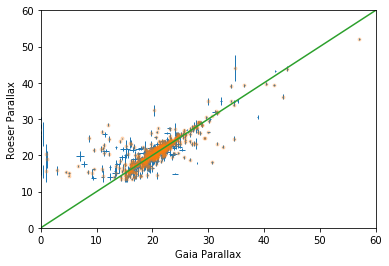

In [100]:
good_ros = hdat["ROESER_PARALLAX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_ros],
             hdat["ROESER_PARALLAX"][good_ros],
            yerr=hdat["ROESER_PARALLAX_ERR"][good_ros],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_ros],
            linewidth=0,elinewidth=1)
good_gaia = good_ros & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],
         hdat["ROESER_PARALLAX"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Roeser Parallax")

Text(0,0.5,'Roeser Parallax')

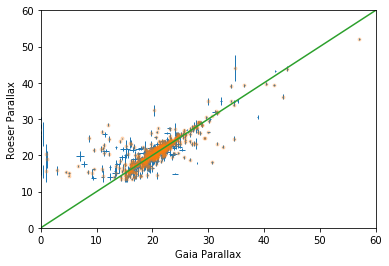

In [101]:
good_ros = hdat["ROESER_PARALLAX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_ros],
             hdat["ROESER_PARALLAX"][good_ros],
            yerr=hdat["ROESER_PARALLAX_ERR"][good_ros],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_ros],
            linewidth=0,elinewidth=1)
good_gaia = good_ros & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],
         hdat["ROESER_PARALLAX"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Roeser Parallax")

Text(0,0.5,'Goldman Parallax')

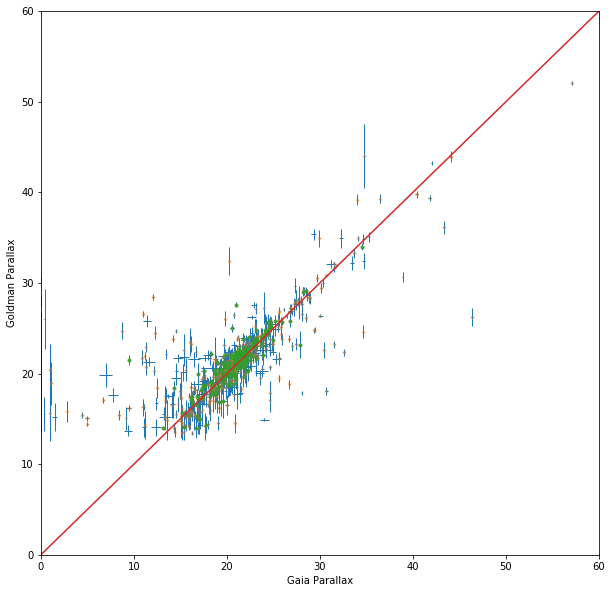

In [110]:
plt.figure(figsize=(10,10))
good_g = hdat["GOLDMAN_PLX"]>-999
plt.errorbar(hdat["GAIA_PARALLAX"][good_g],
             hdat["GOLDMAN_PLX"][good_g],
            yerr=hdat["GOLDMAN_E_PLX"][good_g],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
rot = (hdat["PERIOD"]>0) | (hdat["K2FOV_FLAG13"]==2)
rot_good = rot & good_gaia
plt.plot(hdat["GAIA_PARALLAX"][good_gaia],
         hdat["GOLDMAN_PLX"][good_gaia],'.',alpha=0.25)
plt.plot(hdat["GAIA_PARALLAX"][rot_good],
         hdat["GOLDMAN_PLX"][rot_good],'.',alpha=0.75)

x = np.linspace(0,60)
plt.plot(x,x)
plt.xlim(0,60)
plt.ylim(0,60)

plt.xlabel("Gaia Parallax")
plt.ylabel("Goldman Parallax")

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


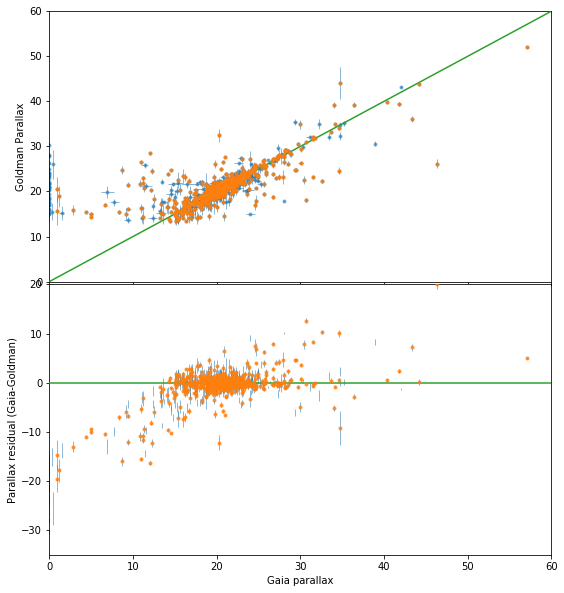

In [128]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,
                        figsize=(9,10))
good_g = hdat["GOLDMAN_PLX"]>-999

axes[0].errorbar(hdat["GAIA_PARALLAX"][good_g],
             hdat["GOLDMAN_PLX"][good_g],
            yerr=hdat["GOLDMAN_E_PLX"][good_g],
             xerr=hdat["GAIA_PARALLAX_ERR"][good_g],
#             linewidth=0,elinewidth=1)
            linewidth=0,elinewidth=1,marker=".",alpha=0.5)

axes[0].plot(hdat["GAIA_PARALLAX"][hdat["GAIA_QUAL"]],
             hdat["GOLDMAN_PLX"][hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
x = np.linspace(0,60)
axes[0].plot(x,x,zorder=3)
axes[0].set_xlim(0,60)
axes[0].set_ylim(0,60)
axes[0].set_ylabel("Goldman Parallax")
# axes[0].set_xlabel("Gaia parallax")

par_diff = hdat["GAIA_PARALLAX"]-hdat["GOLDMAN_PLX"]
diff_err = np.sqrt(hdat["GAIA_PARALLAX_ERR"]**2 + hdat["GOLDMAN_E_PLX"]**2)
par_diff[(hdat["GAIA_PARALLAX"]<0) | (hdat["GOLDMAN_PLX"]<0)] = np.nan
diff_err[(hdat["GAIA_PARALLAX"]<0) | (hdat["GOLDMAN_PLX"]<0)] = np.nan
sig_diff = (abs(par_diff) - 3*diff_err) > 0

axes[1].errorbar(hdat["GAIA_PARALLAX"],par_diff,diff_err,
            linewidth=0,elinewidth=1,alpha=0.5)
axes[1].plot(hdat["GAIA_PARALLAX"][hdat["GAIA_QUAL"]],par_diff[hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
# axes[1].plot(hdat["GAIA_PARALLAX"][sig_diff & hdat["GAIA_QUAL"]],
#              par_diff[sig_diff & hdat["GAIA_QUAL"]],
#          "o",zorder=5,alpha=0.75,mfc="none",mew=2)
# axes[1].set_xlim(0,3.5)
axes[1].plot(x,np.zeros_like(x),zorder=3)
axes[1].set_ylabel("Parallax residual (Gaia-Goldman)")
axes[1].set_xlabel("Gaia parallax")
axes[1].set_ylim(-35,20)
# axes[1].set_ylim(-0.25,0.25)
plt.subplots_adjust(hspace=0.01)

35
5.297694383719378 -11.599060748583389 inf
-1.8864357191945433 -3.9067993814227315 inf
5.551254668613857 -32.76236195602431 inf
15.112416362905668 -21.58255530461131 inf
13.432780860795267 2.95212846936598 inf
23.84744260484129 -8.072830073644496 inf
-32.02816451450976 27.42254183849059 -2.593750000000002
-5.9190972036588265 22.227382976356658 -4.890243902439031
-0.24390128193141133 -1.129367210888345 -1.3499999999999979
-1.9605469797070372 -2.7168961622506256 -1.210526315789476
2.11019179172453 27.036450728625667 -2.822115384615387
2.576889922095673 -0.7080620466780647 -3.999999999999986
0.5843794625246849 -1.6738809645031785 -0.4137931034482793
-1.2447885439591704 3.9018196123022166 -0.6784037558685447
-0.6856931858797591 5.237941422872031 inf
-3.8644261180971693 -0.3711511840375529 -5.461538461538468
-3.5996428816990367 13.455445849588575 -0.5555555555555545
3.5628985712668437 -14.943156633055766 -0.7349397590361438
-0.3490461637019015 -1.13033312921052 -0.4629629629629629
-1.9772

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars


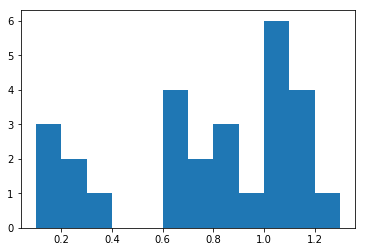

In [141]:

axes[1].plot(hdat["GAIA_PARALLAX"][sig_diff & hdat["GAIA_QUAL"] & rot],
             par_diff[sig_diff & hdat["GAIA_QUAL"] & rot],
         ".",zorder=4,alpha=0.75)
print(len(np.where(sig_diff & hdat["GAIA_QUAL"] & rot)[0]))
plt.hist(hdat["KH_MASS"][sig_diff & hdat["GAIA_QUAL"] & rot],
        bins=np.arange(0.1,1.4,0.1))

pmra_diff = hdat["GOLDMAN_PMRA"]-hdat["GAIA_PMRA"]
pmra_err = np.sqrt(hdat["GOLDMAN_E_PMRA"]**2+hdat["GAIA_PMRA_ERR"]**2)
pmde_diff = hdat["GOLDMAN_PMDE"]-hdat["GAIA_PMDEC"]
pmde_err = np.sqrt(hdat["GOLDMAN_E_PMDE"]**2+hdat["GAIA_PMDEC_ERR"]**2)
rv_diff = hdat["GOLDMAN_RV"]-hdat["GAIA_RV"]
rv_err = hdat["GAIA_RV_ERR"]*2

for i in np.where(sig_diff & hdat["GAIA_QUAL"] & rot)[0]:
    print(pmra_diff[i]/pmra_err[i],
         pmde_diff[i]/pmde_err[i],
         rv_diff[i]/rv_err[i])

Text(0,0.5,'Goldman PMRA')

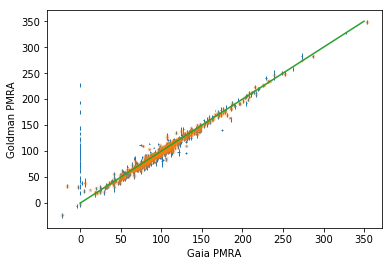

In [20]:
good_g = hdat["GOLDMAN_PMRA"]>-999
plt.errorbar(hdat["GAIA_PMRA"][good_g],
             hdat["GOLDMAN_PMRA"][good_g],
            yerr=hdat["GOLDMAN_E_PMRA"][good_g],
             xerr=hdat["GAIA_PMRA_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PMRA"][good_gaia],
         hdat["GOLDMAN_PMRA"][good_gaia],'.',alpha=0.25)

x = np.linspace(0,350)
plt.plot(x,x)

plt.xlabel("Gaia PMRA")
plt.ylabel("Goldman PMRA")

Text(0,0.5,'Goldman PMDE')

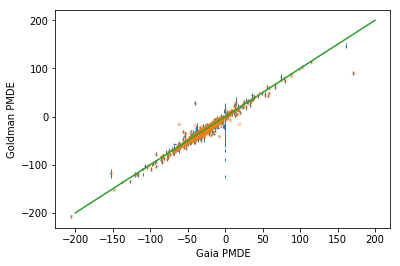

In [21]:
good_g = hdat["GOLDMAN_PMDE"]>-999
plt.errorbar(hdat["GAIA_PMDEC"][good_g],
             hdat["GOLDMAN_PMDE"][good_g],
            yerr=hdat["GOLDMAN_E_PMDE"][good_g],
             xerr=hdat["GAIA_PMDEC_ERR"][good_g],
            linewidth=0,elinewidth=1)
good_gaia = good_g & hdat["GAIA_QUAL"]
plt.plot(hdat["GAIA_PMDEC"][good_gaia],
         hdat["GOLDMAN_PMDE"][good_gaia],'.',alpha=0.25)

x = np.linspace(-200,200)
plt.plot(x,x)

plt.xlabel("Gaia PMDE")
plt.ylabel("Goldman PMDE")

# Look at XYZ (uvw) positions

In [22]:
c = SkyCoord(hdat["RA"]*u.degree, hdat["DEC"]*u.degree,
            pm_ra_cosdec = hdat["GAIA_PMRA"]*u.mas/u.yr,
            pm_dec = hdat["GAIA_PMDEC"]*u.mas/u.yr,
            radial_velocity = hdat["GAIA_RV"]*u.km/u.s,
            obstime=Time(2000, format='decimalyear'),
            distance=Distance(parallax=hdat["GAIA_PARALLAX"] * u.mas))

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/units/equivalencies.py:50: RuntimeWarning: divide by zero encountered in true_divide
  (si.arcsecond, astrophys.parsec, lambda x: 1. / x)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/distances.py:162: RuntimeWarning: invalid value encountered in less
  if not allow_negative and np.any(distance.value < 0):


In [23]:
g = c.transform_to('galactic')
g.set_representation_cls('cartesian')

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: inval

In [24]:
g.u, g.v, g.w # cartesian XYZ components

(<Quantity [  -44.49626884,   -46.24227576,   -40.43301434,   -48.60518773,
              -43.29811508,   -43.94031614,   -40.74848224,   -42.48926646,
              -41.95689653,   -39.73662142,   -41.18768401,   -53.08661845,
              -40.96826332,   -46.56631625,   -42.23599187,   -42.81018555,
              -44.41231178,   -47.37301509,   -42.80840566,   -42.63143952,
              -44.66522453,   -41.88672638,   -43.09019176,   -49.69286772,
              -43.48798902,   -41.30894294,   -43.934788  ,   -54.06025292,
              -45.2304711 ,   -41.67692215,   -47.33793473,   -45.66810097,
              -41.19617159,   -43.0393413 ,   -66.03240684,   -38.15443424,
              -43.39279422,   -43.71245551,   -42.94222209,   -39.38753283,
              -42.39862641,   -43.14009134,   -41.5400651 ,   -42.60763313,
              -35.86531421,   -60.70726412,   -43.01865237,   -48.74818177,
              -42.08387151,   -44.76880584,   -44.42901416,   -43.05156949,
            

In [25]:
# Roser and Goldman use the van Leeuwen (2009) cluster center

In [26]:
from matplotlib.patches import Circle
def add_circles(ax,center):
    inner = Circle(center,radius=9,fill=False,color="k")
    ax.add_patch(inner)
    middle = Circle(center,radius=18,fill=False,color="k",
                  linestyle="--")
    ax.add_patch(middle)
    outer = Circle(center,radius=30,fill=False,color="k",
                  linestyle=":")
    ax.add_patch(outer)

(0.0, 1.0, 0.0, 1.0)

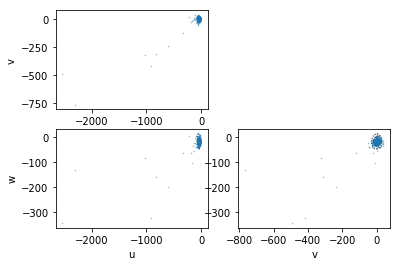

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=2)

axes[0][0].plot(g.u,g.v,'.',alpha=0.5,ms=1)
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])

axes[1][0].plot(g.u,g.w,'.',alpha=0.5,ms=1)
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])

axes[1][1].plot(g.v,g.w,'.',alpha=0.5,ms=1)
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])

axes[0][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

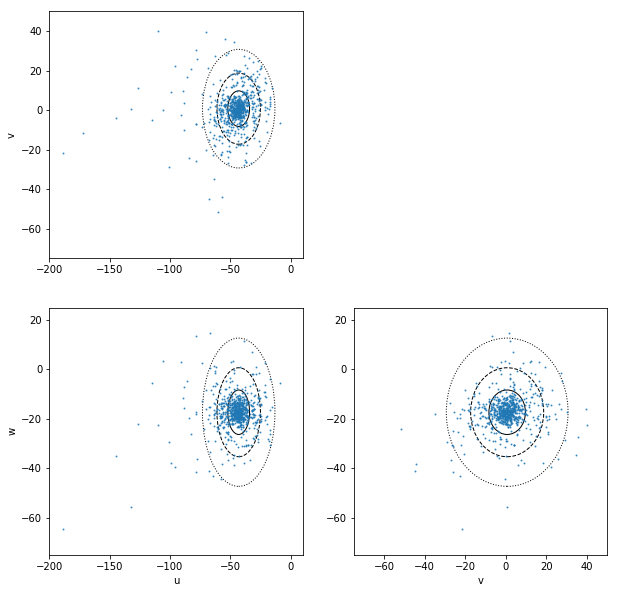

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axes[0][0].plot(g.u,g.v,'.',alpha=0.75,ms=2)
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])
axes[0][0].set_xlim(-200,10)
axes[0][0].set_ylim(-75,50)

axes[1][0].plot(g.u,g.w,'.',alpha=0.75,ms=2)
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])
axes[1][0].set_xlim(-200,10)
axes[1][0].set_ylim(-75,25)

axes[1][1].plot(g.v,g.w,'.',alpha=0.75,ms=2)
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])
axes[1][1].set_xlim(-75,50)
axes[1][1].set_ylim(-75,25)

axes[0][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

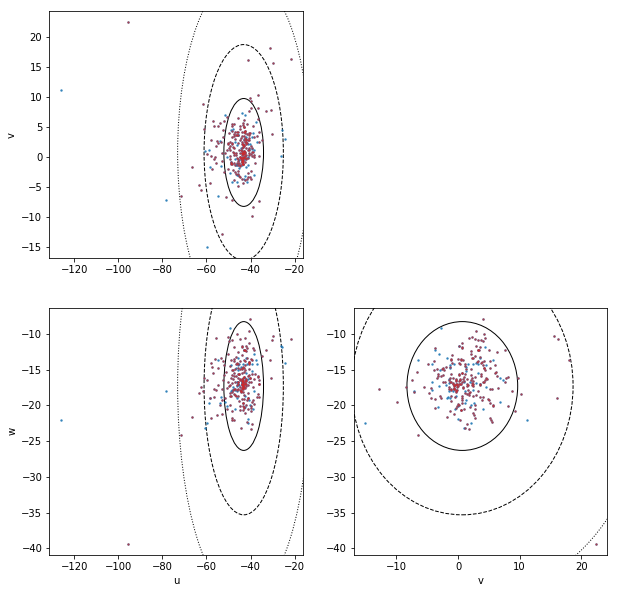

In [29]:
# Compare to the Gaia HRD quality cuts
rot = (hdat["PERIOD"]>0) | (hdat["K2FOV_FLAG13"]==2)
rot_good = rot & hdat["GAIA_QUAL"]

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axes[0][0].plot(g.u[rot],g.v[rot],'.',alpha=0.75,ms=3)
axes[0][0].plot(g.u[rot_good],g.v[rot_good],'.',alpha=0.5,ms=3,color="C3")
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])

axes[1][0].plot(g.u[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][0].plot(g.u[rot_good],g.w[rot_good],'.',alpha=0.5,ms=3,color="C3")
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])

axes[1][1].plot(g.v[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][1].plot(g.v[rot_good],g.w[rot_good],'.',alpha=0.5,ms=3,color="C3")
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])

axes[0][1].axis('off')

(0.0, 1.0, 0.0, 1.0)

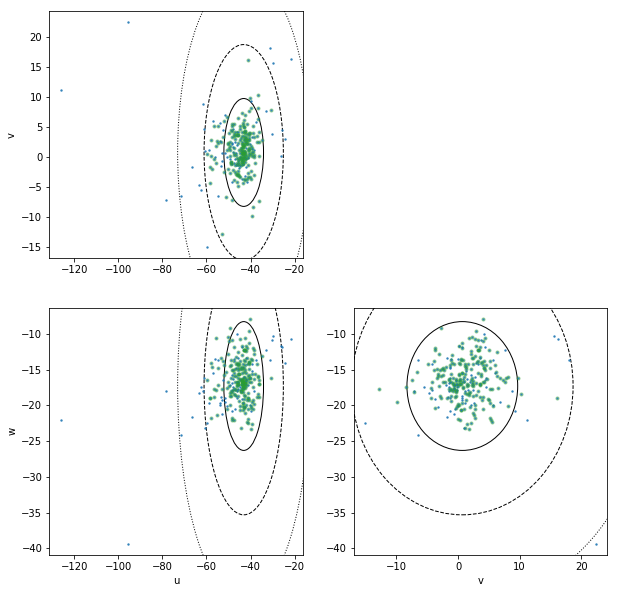

In [30]:
# Compare to the Gaia HRD Hyades cluster list
rot = (hdat["PERIOD"]>0) | (hdat["K2FOV_FLAG13"]==2)
rot_good = rot & hdat["HRD"]

fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10))

axes[0][0].plot(g.u[rot],g.v[rot],'.',alpha=0.75,ms=3)
axes[0][0].plot(g.u[rot_good],g.v[rot_good],'o',alpha=0.5,ms=3,color="C2",
               mfc="none")
# axes[0][0].set_xlabel("u")
axes[0][0].set_ylabel("v")
add_circles(axes[0][0],[-43.1,0.7])

axes[1][0].plot(g.u[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][0].plot(g.u[rot_good],g.w[rot_good],'o',alpha=0.5,ms=3,color="C2",
               mfc="none")
axes[1][0].set_xlabel("u")
axes[1][0].set_ylabel("w")
add_circles(axes[1][0],[-43.1,-17.3])

axes[1][1].plot(g.v[rot],g.w[rot],'.',alpha=0.75,ms=3)
axes[1][1].plot(g.v[rot_good],g.w[rot_good],'o',alpha=0.5,ms=3,color="C2",
               mfc="none")
axes[1][1].set_xlabel("v")
# axes[1][1].set_ylabel("w")
add_circles(axes[1][1],[0.7,-17.3])

axes[0][1].axis('off')

In [31]:
# Check the period and parallax of the outlier

In [32]:
print(len(np.where(rot & np.isnan(g.u))[0]))

9


# Compare masses

so, compare how mass changes when absolute K is calculated using Gaia vs an earlier parallax

In [33]:
import convertmass

In [34]:
def calc_mass_unc(mK,mK_err,dist,dist_err):
    # dmod = m-M = 5*log10(d) - 5
    # M = m-dmod = m - 5*log10(d) + 5
    # dM/dd = -5/(d*ln(10))
    dmod = 5.0*np.log10(dist) - 5
    MK = mK - dmod
    
    bad = np.where(mK<-99)[0]
    MK[bad] = -9999

    if type(mK_err)==np.ndarray:
        mK_err_sq = mK_err**2 
    else:
        # actually a fraction, but real errors
        mK_err_sq = (mK_err*mK)**2

    dist_err_sq = (dist_err * 5.0 / (dist * np.log(10.0)))**2

    sigma_MK = np.sqrt(mK_err_sq + dist_err_sq)
    #print(sigma_MK)

    MK_low =  MK + sigma_MK #dimmer/lower mass
    MK_high = MK - sigma_MK #brighter/higher mass
    #print('low',MK_low)
    #print('high',MK_high)
    
    good = np.where((MK>0) & (MK_low>0) & (MK_high>0))[0]

    mass, mass_low, mass_high = np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.,np.ones(len(MK))*-9999.
    
    mass[good] = convertmass.kraus(MK[good],'K','None')
    mass_low[good] = convertmass.kraus(MK_low[good],'K','None')
    mass_high[good] = convertmass.kraus(MK_high[good],'K','None')

    mass_errs = np.zeros(2*len(mK)).reshape((2,-1))
    
    mass_errs[1][good] = abs(mass_low-mass)[good]
    mass_errs[0][good] = abs(mass_high-mass)[good]

    return mass,mass_errs

In [35]:
def hyades_mass_unc(dist=hdat["DISTANCE"],e_dist=hdat["DISTANCE_ERR"]):
    #mK,mK_err,dist,dist_err
    
    mK = np.copy(hdat["TWOMASS_K"])
    e_mK = np.copy(hdat["TWOMASS_KERR"])
    
    mass,mass_errs = calc_mass_unc(mK, e_mK, dist, e_dist)
    
    good_mass = np.where(mass>0)[0]
    good_errs = np.zeros(2*len(good_mass)).reshape((2,-1))
    good_errs[0] = mass_errs[0][good_mass]
    good_errs[1] = mass_errs[1][good_mass]

    
    plt.plot(mass[good_mass], good_errs[0],'ko')
    plt.plot(mass[good_mass], good_errs[1],'ro')
    plt.xlim(1.2,0.1)
    plt.ylim(0,0.3)
    plt.xlabel("mass")
    plt.ylabel("mass errors")
    
    plt.figure()
    plt.plot(dist,e_dist,'ko')
    plt.xlabel("distance")
    plt.ylabel("distance error")
#     plt.figure()
#     plt.plot(mK,e_mK,'ko')
#     plt.xlim(0,13)
#     plt.ylim(0,0.5)
    
    return mass, mass_errs

0.025564968390695924


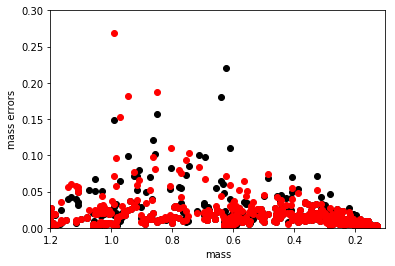

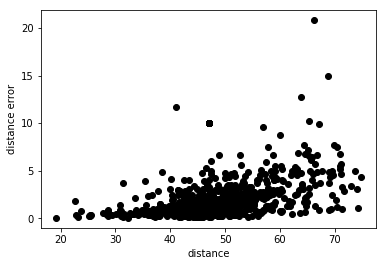

In [36]:
mass, mass_errs = hyades_mass_unc()
good_mass = np.where(mass>0)[0]
mass_errs2 = (mass_errs[0]+mass_errs[1])/2.0
print(np.median(mass_errs2[good_mass]/mass[good_mass]))

In [37]:
gdist = 1000/hdat["GAIA_PARALLAX"]
e_gdist = abs(1000.0 * hdat["GAIA_PARALLAX_ERR"] / (hdat["GAIA_PARALLAX"]**2))
print(gdist)
print(e_gdist)

  GAIA_PARALLAX   
------------------
47.995238872303865
 49.22955742627874
  44.2020209163963
 52.45709010029796
46.689046282851585
 46.53955163795952
 44.17468437188016
 44.89237054162645
45.055801610294345
 49.17653885684218
               ...
 37.30702939047775
37.215533763793005
21.577812829735954
59.335560394700146
  50.1869463752478
 40.50354000939682
 58.46517229686276
42.219388832127265
 36.58246602403468
 44.54283461690935
  678.656260604004
Length = 786 rows
 GAIA_PARALLAX_ERR 
-------------------
 0.8594518762901875
 1.0326743671214182
 0.9014919265373573
 1.0178709570324092
 0.7535800366967403
 0.7892648434117422
 0.6738193658993622
 1.0030272190777978
 0.9218344699966508
 0.6082104914455349
                ...
0.36047994046297044
 0.2164748675045439
0.03990209195834558
 0.3415087465532515
0.20099462100046545
0.16946744661514718
  0.541780954914743
0.18787305401997034
0.20448869815706677
 0.4245897207617984
 124.76958330344398
Length = 786 rows


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


0.007858093535060635


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


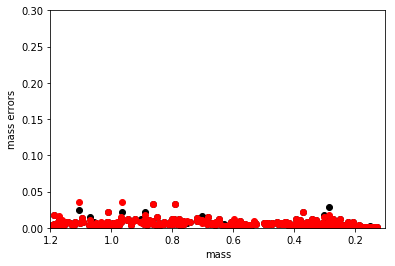

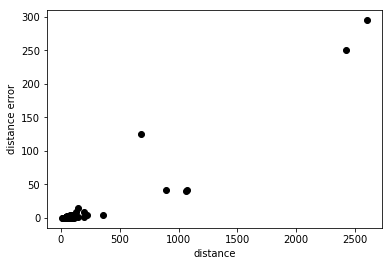

In [38]:
gmass, gmass_errs = hyades_mass_unc(dist=gdist,e_dist=e_gdist)
good_gmass = np.where(gmass>0)[0]
gmass_errs2 = (gmass_errs[0]+gmass_errs[1])/2.0
print(np.median(gmass_errs2[good_gmass]/gmass[good_gmass]))

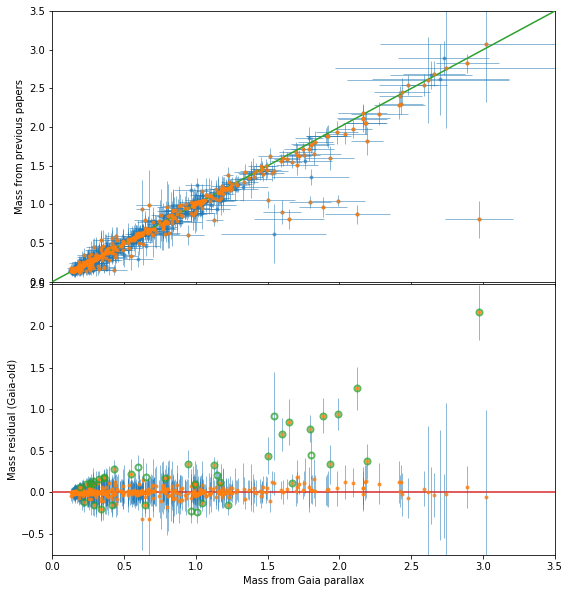

In [39]:
fig, axes = plt.subplots(nrows=2,ncols=1,sharex=True,
                        figsize=(9,10))

axes[0].errorbar(gmass,mass,yerr=np.sqrt(mass_errs2),xerr=np.sqrt(gmass_errs2),
            linewidth=0,elinewidth=1,marker=".",alpha=0.5)

axes[0].plot(gmass[hdat["GAIA_QUAL"]],mass[hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
axes[0].set_xlim(0,3.5)
axes[0].set_ylim(0,3.5)
x = np.linspace(0,4,10)
axes[0].plot(x,x,zorder=3)
axes[0].set_ylabel("Mass from previous papers")
# axes[0].set_xlabel("Mass from Gaia parallax")

mass_diff = gmass-mass
diff_err = np.sqrt(gmass_errs2 + mass_errs2)
mass_diff[(gmass<0) | (mass<0)] = -9999
sig_diff = (abs(mass_diff) - diff_err) > 0

axes[1].errorbar(gmass,mass_diff,diff_err,
            linewidth=0,elinewidth=1,alpha=0.5)
axes[1].plot(gmass[hdat["GAIA_QUAL"]],mass_diff[hdat["GAIA_QUAL"]],
         ".",zorder=4,alpha=0.75)
axes[1].plot(gmass[sig_diff],mass_diff[sig_diff],
         "o",zorder=5,alpha=0.75,mfc="none",mew=2)
axes[1].set_xlim(0,3.5)
x = np.linspace(0,4,10)
axes[1].plot(x,np.zeros_like(x),zorder=3)
axes[1].set_ylabel("Mass residual (Gaia-old)")
axes[1].set_xlabel("Mass from Gaia parallax")
axes[1].set_ylim(-0.75,2.5)
# axes[1].set_ylim(-0.25,0.25)

plt.subplots_adjust(hspace=0.01)

# CMD

(16, -2)

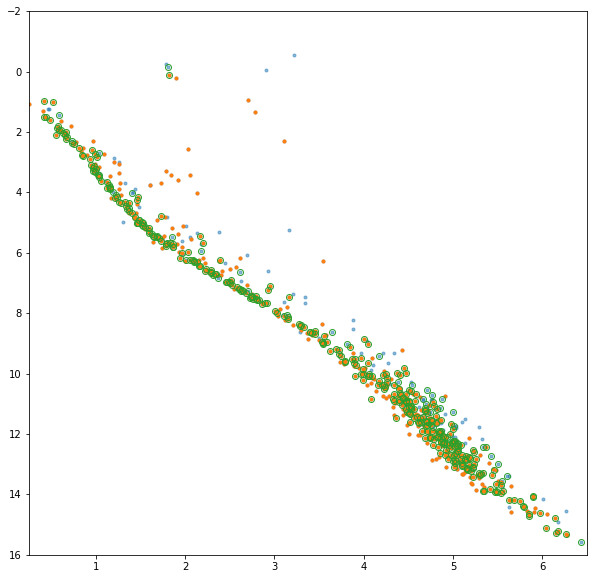

In [40]:
dmod = 5.0*np.log10(gdist) - 5
Mr = hdat["RPRIME"] - dmod

bad = np.where(hdat["RPRIME"]<-99)[0]
Mr[bad] = -9999

plt.figure(figsize=(10,10))
plt.plot(hdat["RPRIME_K"],Mr,'.',alpha=0.5,zorder=-11)
plt.plot(hdat["RPRIME_K"][hdat["GAIA_QUAL"]],Mr[hdat["GAIA_QUAL"]],
         '.')
plt.plot(hdat["RPRIME_K"][hdat["HRD"]],Mr[hdat["HRD"]],
         'o',mfc="none")
plt.xlim(0.25,6.5)
plt.ylim(16,-2)

# Check cross-matching with photometry

## Tycho photometry (from 2MASS), take 1

In [41]:
g_calc = np.ones(len(hdat))*np.nan

In [42]:
tycho_b = hdat["TWOMASS_B"]
tycho_v = hdat["TWOMASS_VR"]
tycho_v[hdat["TWOMASS_PHOT_FLAG"]!="T"] = np.nan
tycho_b[hdat["TWOMASS_PHOT_FLAG"]!="T"] = np.nan

In [43]:
tgood = np.isfinite(tycho_b) & (hdat["TWOMASS_PHOT_FLAG"]=="T")

In [44]:
bv = tycho_b - tycho_v
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_v = -0.02051 - 0.2706*bv + 0.03394*bv**2 -0.05937*bv**3
g_calc[tgood] = tycho_v[tgood] + g_m_v[tgood]
g_tycho = np.copy(g_calc)

Text(0,0.5,'Calculated G')

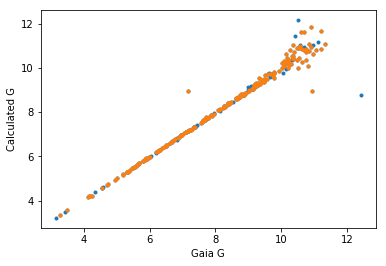

In [45]:
plt.plot(hdat["GAIA_G"],g_calc,'.')
plt.plot(hdat["GAIA_G"][hdat["GAIA_QUAL"]],g_calc[hdat["GAIA_QUAL"]],
        '.')

plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

## UCAC r, i photometry

In [46]:
g_calc = np.ones(len(hdat))*np.nan

ucac_r = hdat["UCAC_R"]
ucac_i = hdat["UCAC_I"]
ugood = (ucac_r>0) & (ucac_i>0)

In [47]:
ri = ucac_r - ucac_i
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_r = 0.0014891 + 0.36291*ri -0.81282*ri**2 + 0.0060376*ri**3
g_calc[ugood] = ucac_r[ugood] + g_m_r[ugood]
g_ucac = np.copy(g_calc)

Text(0,0.5,'Calculated G')

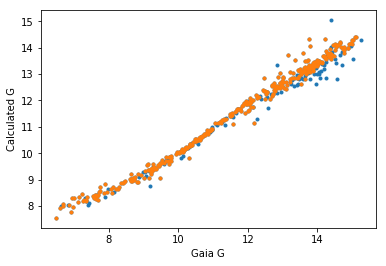

In [48]:
plt.plot(hdat["GAIA_G"],g_calc,'.')
plt.plot(hdat["GAIA_G"][hdat["GAIA_QUAL"]],g_calc[hdat["GAIA_QUAL"]],
        '.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

In [49]:
len(np.where(np.isnan(g_calc))[0])

337

## SDSS r,i photometry

In [50]:
g_calc = np.ones(len(hdat))*np.nan

sdss_r = hdat["SDSS_R"]
sdss_i = hdat["SDSS_I"]
sgood = (sdss_r>14) & (sdss_i>14)

In [51]:
ri = sdss_r - sdss_i
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_r = 0.0014891 + 0.36291*ri -0.81282*ri**2 + 0.0060376*ri**3
g_calc[sgood] = sdss_r[sgood] + g_m_r[sgood]
g_sdss = g_calc

Text(0,0.5,'Calculated G')

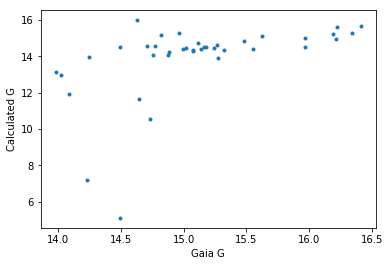

In [52]:
plt.plot(hdat["GAIA_G"],g_calc,'.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

In [53]:
len(np.where(np.isnan(g_calc))[0])

747

## PanSTARRS-1 r,i photometry

In [142]:
g_calc = np.ones(len(hdat))*np.nan

ps_r = hdat["GOLDMAN_RMED"]
ps_i = hdat["GOLDMAN_IMED"]
pgood = (ps_r>14) & (ps_i>14)

In [143]:
ri = ps_r - ps_i
# https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu5pho/sec_cu5pho_calibr/ssec_cu5pho_PhotTransf.html#Ch5.T7
g_m_r = 0.0014891 + 0.36291*ri -0.81282*ri**2 + 0.0060376*ri**3
g_calc[pgood] = ps_r[pgood] + g_m_r[pgood]
g_ps = g_calc

Text(0,0.5,'Calculated G')

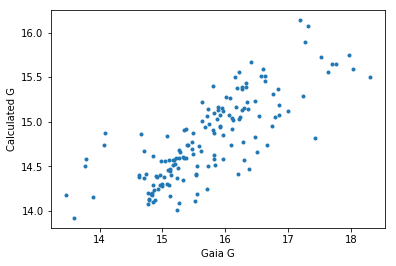

In [144]:
plt.plot(hdat["GAIA_G"],g_calc,'.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")

## General Mag comparisons

(0, 25)

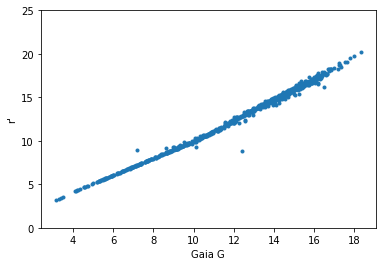

In [54]:
plt.plot(hdat["GAIA_G"],hdat["RPRIME"],'.')
plt.xlabel("Gaia G")
plt.ylabel("r'")
plt.ylim(0,25)

In [55]:
good_phot = (hdat["GAIA_G"]>0) & (hdat["RPRIME"]>0)
med = np.median(abs(hdat["GAIA_G"][good_phot]-hdat["RPRIME"][good_phot]))
print(med)

0.5498997253417963


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [56]:
pdiff = abs(hdat["GAIA_G"]-hdat["RPRIME"])
sig_diff = np.where((pdiff>(3*med)) & good_phot)[0]
len(sig_diff)

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


7

In [57]:
print(hdat["GAIA_ID","RA","DEC","GAIA_G",][sig_diff])
print(hdat["RPRIME","PERIOD","EPIC_ID","GAIA_QUAL","GAIA_SEP"][sig_diff])

      GAIA_ID            RA         DEC      GAIA_G
------------------- ----------- ----------- -------
3307844864892259328 67.01821634 13.86798485 12.4074
 226778843075710976  61.0295581  39.5097158  7.1595
3410856112139584000  68.8064706  20.1337081 17.7648
3229683572572779648  71.9777781  -0.7933706 18.3039
  49131681384221952  65.4411692  20.3957222 17.9654
  50667699128858624  57.7391697  18.3018933  17.235
3295557581935254144  72.1916339    11.38568  16.275
  RPRIME   PERIOD  EPIC_ID  GAIA_QUAL       GAIA_SEP      
--------- ------- --------- --------- --------------------
 8.791071   -99.0     -9999     False   0.6297578834102998
 8.943125   -99.0     -9999      True 0.025629182326549937
 19.52922 -9999.0 247254123     False  0.13812394667308217
20.182526 -9999.0     -9999     False  0.10752699628650557
 19.74961 -9999.0 210834592     False   0.1168329634228231
 18.98974 -9999.0     -9999     False  0.08370316663431596
29.911285 -9999.0     -9999     False  0.09994453113020334


## Tycho photometry (from 2MASS)

(0, 15)

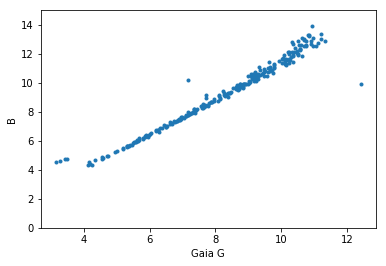

In [58]:
plt.plot(hdat["GAIA_G"],hdat["TWOMASS_B"],'.')
plt.xlabel("Gaia G")
plt.ylabel("B")
plt.ylim(0,15)

In [59]:
good_phot2 = (hdat["GAIA_G"]>0) & (hdat["TWOMASS_B"]>0)
med2 = np.median(abs(hdat["GAIA_G"][good_phot2]-hdat["TWOMASS_B"][good_phot2]))
print(med)

0.5498997253417963


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [60]:
pdiff2 = abs(hdat["GAIA_G"]-hdat["TWOMASS_B"])
sig_diff2 = np.where((pdiff2>(3*med2)) & good_phot2)[0]
len(sig_diff2)

/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


2

In [61]:
print(hdat["GAIA_ID","RA","DEC","GAIA_G","TWOMASS_B"][sig_diff2])
print(hdat["RPRIME","PERIOD","EPIC_ID","GAIA_QUAL","GAIA_SEP"][sig_diff2])

      GAIA_ID           RA        DEC      GAIA_G TWOMASS_B
------------------- ---------- ---------- ------- ---------
 226778843075710976 61.0295581 39.5097158  7.1595     10.21
3308896238528440448 71.8972317 14.8890903 10.9281     13.92
 RPRIME  PERIOD EPIC_ID GAIA_QUAL       GAIA_SEP      
-------- ------ ------- --------- --------------------
8.943125  -99.0   -9999      True 0.025629182326549937
  10.971  -99.0   -9999      True 0.017647093237017453


(3, 13)

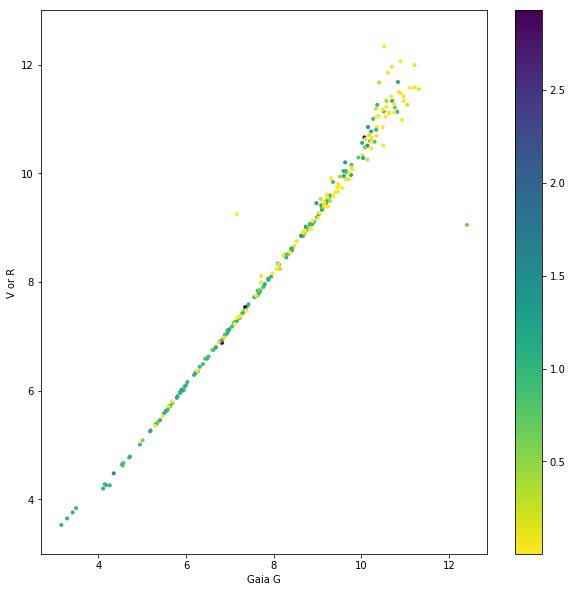

In [62]:
plt.figure(figsize=(10,10))
# plt.plot(hdat["GAIA_G"],hdat["TWOMASS_VR"],'k.',zorder=-11)
sc = plt.scatter(hdat["GAIA_G"],hdat["TWOMASS_VR"],c=hdat["GAIA_SEP"],
                cmap="viridis_r",marker=".")
plt.colorbar(sc)
plt.xlabel("Gaia G")
plt.ylabel("V or R")
plt.ylim(3,13)

## 2MASS

In [63]:
jmk = hdat["TWOMASS_J"] - hdat["TWOMASS_K"]
need_jmk = hdat["TWOMASS_J"]<=0
jmk[need_jmk] = hdat["GOLDMAN_JMAG"][need_jmk] - hdat["GOLDMAN_KMAG"][need_jmk]
hmk = hdat["TWOMASS_H"] - hdat["TWOMASS_K"]
hmk[need_jmk] = hdat["GOLDMAN_HMAG"][need_jmk] - hdat["GOLDMAN_KMAG"][need_jmk]

In [64]:
print(max(jmk),max(hmk))

1.446 0.582


Text(0,0.5,'H-K')

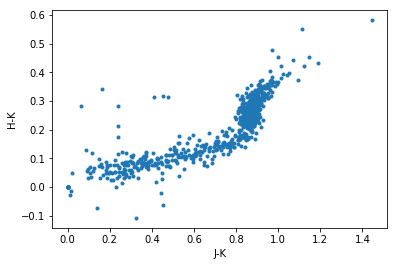

In [65]:
plt.plot(jmk,hmk,'.')
plt.xlabel("J-K")
plt.ylabel("H-K")

(15, 0)

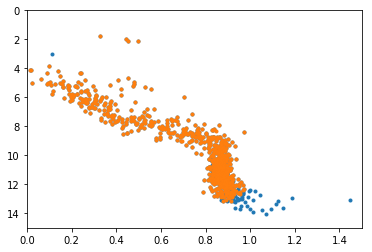

In [66]:
plt.plot(hdat["GOLDMAN_JMAG"] - hdat["GOLDMAN_KMAG"],hdat["GOLDMAN_JMAG"],'.')
plt.plot(hdat["TWOMASS_J"] - hdat["TWOMASS_K"],hdat["TWOMASS_J"],'.')
plt.xlim(0,1.5)
plt.ylim(15,0)

(15, 0)

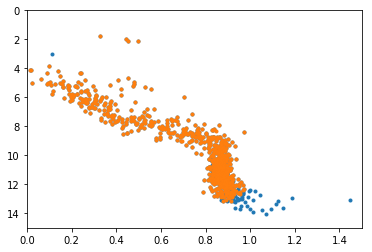

In [67]:
plt.plot(jmk,hdat["GOLDMAN_JMAG"],'.')
plt.plot(jmk,hdat["TWOMASS_J"],'.')
plt.xlim(0,1.5)
plt.ylim(15,0)

In [68]:
hdat["HIP_ID"][np.where(jmk<=0)[0]]

HIP14838
HIP14232
HIP17928
HIP20218
HIP20626
HIP13600
HIP19981
HIP20187
HIP21475
HIP20895
HIP19757


In [69]:
calc_bprp = 0.20215 + 1.9561*jmk -0.69629*jmk**2 + 0.47633*jmk**3

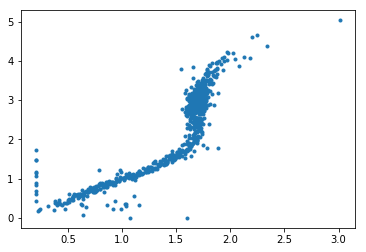

In [70]:
plt.plot(calc_bprp,hdat["GAIA_BP"]-hdat["GAIA_RP"],'.')

In [71]:
calc_GmK = 0.23587 + 4.0548*jmk - 2.5608*jmk**2 + 2.2228*jmk**3 -0.54944*jmk**4

In [72]:
kmag = hdat["TWOMASS_K"]
kmag[kmag<=0] = hdat["GOLDMAN_KMAG"][kmag<=0]

In [73]:
calc_G = calc_GmK + kmag

(0, 20)

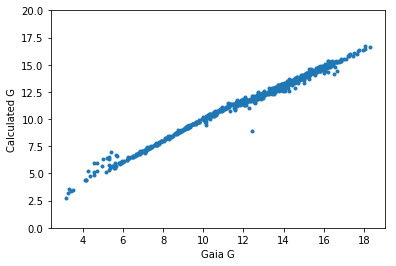

In [74]:
plt.plot(hdat["GAIA_G"],calc_G,'.')
plt.xlabel("Gaia G")
plt.ylabel("Calculated G")
plt.ylim(0,20)

In [145]:
ucac_diff = abs(hdat["GAIA_G"] - g_ucac)
sdss_diff = abs(hdat["GAIA_G"] - g_sdss)
ps_diff = abs(hdat["GAIA_G"] - g_sdss)
tycho_diff = abs(hdat["GAIA_G"] - g_tycho)
gK_diff = abs(hdat["GAIA_G"]-calc_G)

In [76]:
print(np.median(ucac_diff[np.isfinite(ucac_diff)]),np.median(sdss_diff[np.isfinite(sdss_diff)]))
print(np.median(tycho_diff[np.isfinite(tycho_diff)]),np.median(gK_diff[gK_diff<10000]))
print(np.std(ucac_diff[np.isfinite(ucac_diff)]),np.std(sdss_diff[np.isfinite(sdss_diff)]))
print(np.std(tycho_diff[np.isfinite(tycho_diff)]),np.std(gK_diff[gK_diff<10000]))

0.3770341217041011 0.7327045837402331
0.03137745742797815 0.7698993469238289
0.3437830782358067 1.7943297486294043
0.3280753103148325 0.5142340043357276


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)


In [146]:
ucac_lim = np.median(ucac_diff[np.isfinite(ucac_diff)]) + np.std(ucac_diff[np.isfinite(ucac_diff)])#*2
sdss_lim = np.median(sdss_diff[np.isfinite(sdss_diff)]) + np.std(sdss_diff[np.isfinite(sdss_diff)])#*2
ps_lim = np.median(ps_diff[np.isfinite(ps_diff)]) + np.std(ps_diff[np.isfinite(ps_diff)])#*2
tycho_lim = np.median(tycho_diff[np.isfinite(ucac_diff)]) + np.std(tycho_diff[np.isfinite(tycho_diff)])#*2
tmass_lim = np.median(gK_diff[gK_diff<10000]) + np.std(gK_diff[gK_diff<10000])*2

print(len(np.where(ucac_diff>ucac_lim)[0]))
print(len(np.where(sdss_diff>sdss_lim)[0]))
print(len(np.where(ps_diff>ps_lim)[0]))
print(len(np.where(tycho_diff>tycho_lim)[0]))
print(len(np.where(gK_diff>tmass_lim)[0]))
# print(np.where(((ucac_diff>0.86) & np.isfinite(ucac_diff))
#                & ((sdss_diff>1.46) & np.isfinite(sdss_diff))
#                & ((tycho_diff>0.06)  & np.isfinite(tycho_diff))
#                & ((gK_diff>1.6) & (gK_diff<10000)))[0])
bad_match = np.where(((ucac_diff>ucac_lim) | np.isnan(ucac_diff))
               & ((sdss_diff>sdss_lim) | np.isnan(sdss_diff))
               & ((ps_diff>sdss_lim) | np.isnan(ps_diff))
               & ((tycho_diff>tycho_lim)  | np.isnan(tycho_diff))
               & ((gK_diff>tmass_lim) | (gK_diff>10000)))[0]

no_match = np.where(np.isnan(ucac_diff) & np.isnan(sdss_diff)
                     & np.isnan(ps_diff)
                    & np.isnan(tycho_diff) & (gK_diff>10000))[0]
print(no_match)
print(hdat["GAIA_G"][no_match])

print(bad_match)
for i in bad_match:
    if i in no_match:
#         continue
        print("\nNo phot",hdat["RMAG"][i],hdat["RMAG_FLAG"][i])
        print("UCAC",hdat["UCAC_R"][i],hdat["UCAC_I"][i])
        print(i,hdat["GOLDMAN_SEQ"][i],hdat["HIP_ID"][i])
    else:
        print("\nUCAC",ucac_diff[i],"SDSS",sdss_diff[i],"PS1",ps_diff[i])
        print("Tycho2",tycho_diff[i],"2MASS",gK_diff[i])
        print(i,hdat["GOLDMAN_SEQ"][i],hdat["GOLDMAN_RMAG"][i])
        print("G=",hdat["GAIA_G"][i],hdat["GAIA_QUAL"][i],hdat["GAIA_ID"][i])
        print("Prot=",hdat["PERIOD"][i],"EPIC",hdat["EPIC_ID"][i])

81
4
4
0
15
[ 9 46 89]
GAIA_G
------
 3.998
6.2899
7.6685
[  9  46  72  89  91 349 443 562]

No phot -9999.0 C
UCAC -9999.0 -9999.0
9 -9999 HIP14838

No phot -9999.0 C
UCAC -9999.0 -9999.0
46 -9999 HIP14232

UCAC 1.1926854217529295 SDSS nan PS1 nan
Tycho2 nan 2MASS 10005.914871875
72 -9999 -9999.0
G= 7.1512 True 64115585330656000
Prot= -99.0 EPIC -9999

No phot -9999.0 C
UCAC -9999.0 7.93
89 -9999 HIP20218

UCAC 0.9727545455932614 SDSS nan PS1 nan
Tycho2 nan 2MASS 10006.498271875
91 -9999 -9999.0
G= 7.7346 True 149726790484381568
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan PS1 nan
Tycho2 nan 2MASS 2.3519606292724617
349 171 -9999.0
G= 16.5088 False 3312212503036012416
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan PS1 nan
Tycho2 nan 2MASS 2.207284149169922
443 336 -9999.0
G= 16.634 True 3313665885609887616
Prot= -99.0 EPIC -9999

UCAC nan SDSS nan PS1 nan
Tycho2 nan 2MASS 1.8483402557373054
562 522 -9999.0
G= 16.207 False 3406246551373367168
Prot= -99.0 EPIC 246953721


/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/Users/sdouglas/anaconda3/envs/py3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [147]:
# but it appears some stars lack Gaia matches?
print(np.where(np.isnan(hdat["GAIA_G"]))[0])
print(hdat["RA"][np.isnan(hdat["GAIA_G"])],hdat["DEC"][np.isnan(hdat["GAIA_G"])])
print(hdat["PERIOD"][np.isnan(hdat["GAIA_G"])],hdat["EPIC_ID"][np.isnan(hdat["GAIA_G"])])

[654 672]
    RA    
----------
77.4394697
79.1257739    DEC    
----------
28.0336228
-9.8306886
PERIOD
------
 -99.0
 -99.0 EPIC_ID
-------
  -9999
  -9999


So every rotator and possible K2 target has a Gaia match that looks reasonable. 3 stars are missing the photometry to confirm their matches, 5 do fail the photometry cross-check, and 2 stars do not have Gaia crossmatches, but none of those 10 stars will be included in the paper anyway.